<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Video_Classification_with_a_CNN_RNN_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs


     |████████████████████████████████| 1.0MB 25.0MB/s 


In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
60,v_CricketShot_g16_c05.avi,CricketShot
587,v_TennisSwing_g24_c06.avi,TennisSwing
47,v_CricketShot_g14_c06.avi,CricketShot
374,v_ShavingBeard_g10_c02.avi,ShavingBeard
483,v_TennisSwing_g09_c01.avi,TennisSwing
100,v_CricketShot_g23_c02.avi,CricketShot
72,v_CricketShot_g18_c04.avi,CricketShot
560,v_TennisSwing_g20_c03.avi,TennisSwing
499,v_TennisSwing_g11_c03.avi,TennisSwing
241,v_Punch_g08_c04.avi,Punch


In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x //2) - (min_dim // 2)
  start_y = (y //2) - (min_dim // 2)
  return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames =0, resize = (IMG_SIZE, IMG_SIZE)):
  cap = cv2.VideoCapture(path)
  frames = []

  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break

  finally:
    cap.release()
  return np.array(frames)

In [ ]:
def build_feature_extractor():
  feature_extractor = keras.applications.InceptionV3(
      weights = 'imagenet',
      include_top = False,
      pooling = 'avg',
      input_shape = (IMG_SIZE, IMG_SIZE, 3)
  )
  preprocess_input = keras.applications.inception_v3.preprocess_input
  inputs = keras.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
  preprocessed = preprocess_input(inputs)

  outputs = feature_extractor(preprocessed)
  return keras.Model(inputs, outputs, name = 'feature_extractor')

feature_extractor = build_feature_extractor()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df['tag']))

print(label_processor.get_vocabulary())

['', 'CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
  num_samples = len(df)
  video_paths = df['video_name'].values.tolist()
  labels = df['tag'].values
  labels = label_processor(labels[..., None]).numpy()
  # `frame_masks` and `frame_features` are what we will feed to our sequence model.
  # `frame_masks` will contain a bunch of booleans denoting if a timestep is
  # masked with padding or not.
  frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype='bool')
  frame_features = np.zeros(shape =(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

  # For each video.
  for idx, path in enumerate(video_paths):
    # Gather all its frames and add a batch dimension.
    frames = load_video(os.path.join(root_dir, path))
    frames = frames[None, ...]

    # Initialize placeholders to store the masks and features of the current video.
    temp_frame_mask = np.zeros(shape = (1, MAX_SEQ_LENGTH,), dtype='bool')
    temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
      video_length = batch.shape[1]
      length = min(MAX_SEQ_LENGTH, video_length)
      for j in range(length):
        temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        temp_frame_mask[i, :length] = 1 

    frame_features[idx,] = temp_frame_features.squeeze()
    frame_masks[idx,] = temp_frame_mask.squeeze()

  return (frame_features, frame_masks), labels 


train_data, train_labels = prepare_all_videos(train_df, 'train')
test_data, test_labels = prepare_all_videos(test_df, 'test')


In [ ]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [ ]:
train_data[0].shape

(594, 20, 2048)

In [ ]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

In [ ]:
# Utility for our sequence model.

def get_sequence_model():
  class_vocab = label_processor.get_vocabulary()

  frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
  mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype = 'bool')

  # Refer to the following tutorial to understand the significance of using `mask`:
  # https://keras.io/api/layers/recurrent_layers/gru/
  x = keras.layers.GRU(16, return_sequences = True)(frame_features_input, mask=mask_input)
  x = keras.layers.GRU(8)(x)
  x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(8, activation ='relu')(x)
  output = keras.layers.Dense(len(class_vocab), activation='softmax')(x)

  rnn_model = keras.Model([frame_features_input, mask_input], output)

  rnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
  return rnn_model


In [ ]:
# Utility for running experiments.
def run_experiment():
  filepath = "/tmp/video_classifier"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only = True, save_best_only= True, verbose=1)

  seq_model = get_sequence_model()
  history = seq_model.fit(
      [train_data[0], train_data[1]],
      train_labels,
      validation_split = 0.3,
      epochs = 30,
      callbacks = [checkpoint]
  )


  seq_model.load_weights(filepath)
  _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  return history, seq_model





In [ ]:
_, sequence_model = run_experiment()


Epoch 1/30
13/13 [==============================] - 7s 158ms/step - loss: 1.5232 - acc: 0.3325 - val_loss: 1.7394 - val_acc: 0.2682

Epoch 00001: val_loss improved from inf to 1.73937, saving model to /tmp/video_classifier
Epoch 2/30
13/13 [==============================] - 0s 16ms/step - loss: 1.2476 - acc: 0.4675 - val_loss: 1.6246 - val_acc: 0.3464

Epoch 00002: val_loss improved from 1.73937 to 1.62465, saving model to /tmp/video_classifier
Epoch 3/30
13/13 [==============================] - 0s 17ms/step - loss: 1.1361 - acc: 0.5470 - val_loss: 1.6241 - val_acc: 0.3408

Epoch 00003: val_loss improved from 1.62465 to 1.62414, saving model to /tmp/video_classifier
Epoch 4/30
13/13 [==============================] - 0s 15ms/step - loss: 1.0714 - acc: 0.5229 - val_loss: 1.6222 - val_acc: 0.3464

Epoch 00004: val_loss improved from 1.62414 to 1.62224, saving model to /tmp/video_classifier
Epoch 5/30
13/13 [==============================] - 0s 15ms/step - loss: 0.9951 - acc: 0.6048 - val

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

Test video path: v_Punch_g07_c05.avi
  Punch: 82.05%
  TennisSwing:  6.92%
  CricketShot:  5.14%
  PlayingCello:  3.15%
  :  1.66%
  ShavingBeard:  1.08%



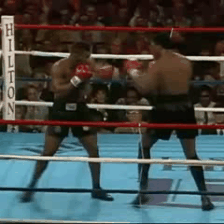

In [ ]:
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])